In [0]:
#!mv "./Assignment 5 Dataset" "./drive/My Drive/"
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! unzip './drive/My Drive/A_05_Part_02_Dataset.zip'

In [3]:
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import natsort
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns 
import time
import os
import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_dir = 'A_05_Part_02_Dataset'
batch_size = 120

In [5]:
#Define transforms for the training data and validation data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),                             
                                      transforms.ToTensor()])


#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform = valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print('Train',class_names)

valid_class_names = valid_data.classes
print('Validation',valid_class_names)

Classes: 
Train ['covid-19', 'normal', 'pneumonia']
Validation ['covid', 'normal', 'pneumonia']


In [0]:
len(trainloader.dataset), len(validloader.dataset)

(6200, 628)

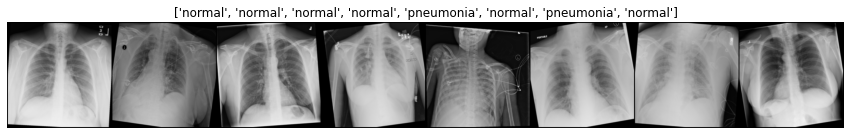

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:8])
    imshow(out, title=[class_names[x] for x in classes[:8]])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def one_hot_label(inp, num_classes):
    # 0: Covid class, 1: Normal class, 2: Pneumunia class
    vector = np.zeros((len(inp), num_classes))
    for i, label in enumerate(inp):
      if label == 0:
        vector[i][0] = 1
        vector[i][2] = 1
      elif label == 1:
        vector[i][1] = 1
      elif label == 2:
        vector[i][2] = 1
    return torch.FloatTensor(vector)

In [0]:
def get_model(name, pretrain):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrain)
        
        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1]
        num_features = model.classifier[5]
        features = list(model.classifier.children())[:-2]
        num_features = model.classifier[4]
        features = list(model.classifier.children())[:-3]
        num_features = model.classifier[3].in_features
        features = list(model.classifier.children())[:-4]
        num_features = model.classifier[2]
        features = list(model.classifier.children())[:-5] 
        num_features = model.classifier[1]
        features = list(model.classifier.children())[:-6] 
        num_features = model.classifier[0]
        features = list(model.classifier.children())[:-7]

        for param in model.features.parameters():
            param.requires_grad = True 

        n_inputs = 25088
        model.classifier = nn.Sequential(
            nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.55),
            nn.Linear(2048, len(class_names)))

    elif name == 'resnet18':
        model = models.resnet18(pretrained=pretrain)
        
        features_num = model.fc
        resnet_feature = list(model.fc.children())[:0]

        for param in model.layer1.parameters():
            param.requires_grad = True
        for param in model.layer2.parameters():
            param.requires_grad = True
        for param in model.layer3.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True
        
        n_inputs = 512
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.50),
            nn.Linear(2048, len(class_names)))

    # get gpu
    if gpu: model = model.to('cuda')
    else: model = model.to('cpu')
    
    return model

In [0]:
def plotCurves(stats):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and Validation Loss Curve')

    plt.figure(figsize=(8, 6))
    for c in ['train_acc', 'valid_acc']:
        plt.plot(100 * stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve')
    plt.show()

In [0]:
class Focal_Loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, logits=False, sampling=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.sampling = sampling

    def forward(self, y_pred, y_true):
        if self.logits: y_pred = torch.sigmoid(y_pred)
        
        pt_positive = torch.where(y_true == 1, y_pred, torch.ones_like(y_pred))
        pt_negative = torch.where(y_true == 0, y_pred, torch.zeros_like(y_pred)) 
        
        pos_loss = -(self.alpha) * ((1-pt_positive) ** self.gamma) * torch.log(pt_positive) 
        neg_loss = -(1-self.alpha) * ((pt_negative) ** self.gamma) * torch.log(pt_negative) 
        loss = pos_loss + neg_loss 

        if self.sampling == None: return loss         
        elif self.sampling == 'mean': return loss.mean()
        elif self.sampling == 'sum': return loss.sum()

In [12]:
# Check if gpu is available
gpu = cuda.is_available()
print('Gpu is available:',gpu)

Gpu is available: True


In [13]:
model = get_model('resnet18', True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size, device='cuda')

In [0]:
# hyper-parameters initialization
Epochs = 300
#criterion = nn.BCEWithLogitsLoss()
FL = Focal_Loss(alpha=0.25, gamma=2, logits=True, sampling='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training Started.......

Epoch 0 : Training Loss: 0.048614, Training Accuracy: 73.382%
	  Validation Loss: 0.040124, Validation Accuracy: 77.919%
	  F1: 0.555556


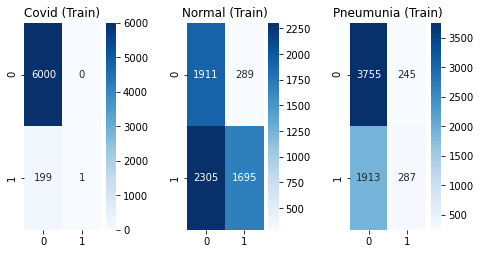

<Figure size 288x360 with 0 Axes>

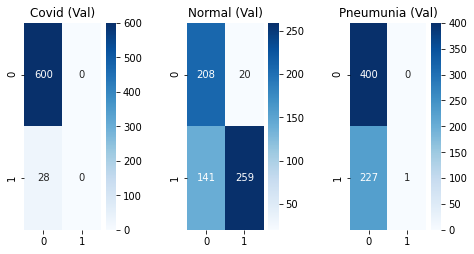

<Figure size 288x360 with 0 Axes>


Epoch 1 : Training Loss: 0.029637, Training Accuracy: 85.296%
	  Validation Loss: 0.027126, Validation Accuracy: 88.854%
	  F1: 0.819588

Epoch 2 : Training Loss: 0.023454, Training Accuracy: 90.312%
	  Validation Loss: 0.026945, Validation Accuracy: 90.180%
	  F1: 0.846981

Epoch 3 : Training Loss: 0.020770, Training Accuracy: 91.849%
	  Validation Loss: 0.022419, Validation Accuracy: 90.340%
	  F1: 0.844710

Epoch 4 : Training Loss: 0.020439, Training Accuracy: 92.108%
	  Validation Loss: 0.025195, Validation Accuracy: 91.295%
	  F1: 0.865132

Epoch 5 : Training Loss: 0.019811, Training Accuracy: 92.188%
	  Validation Loss: 0.021291, Validation Accuracy: 92.144%
	  F1: 0.878489

Epoch 6 : Training Loss: 0.018668, Training Accuracy: 92.855%
	  Validation Loss: 0.023629, Validation Accuracy: 91.773%
	  F1: 0.874494

Epoch 7 : Training Loss: 0.018588, Training Accuracy: 92.796%
	  Validation Loss: 0.020349, Validation Accuracy: 92.144%
	  F1: 0.878089


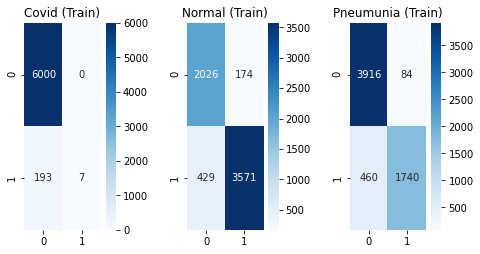

<Figure size 288x360 with 0 Axes>

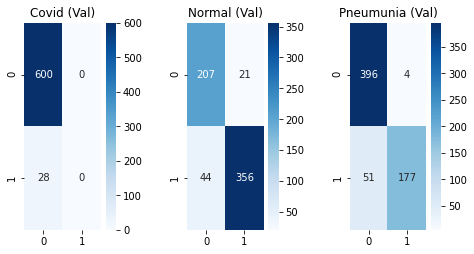

<Figure size 288x360 with 0 Axes>


Epoch 8 : Training Loss: 0.017684, Training Accuracy: 93.129%
	  Validation Loss: 0.019817, Validation Accuracy: 92.622%
	  F1: 0.885972

Epoch 9 : Training Loss: 0.017987, Training Accuracy: 92.876%
	  Validation Loss: 0.018610, Validation Accuracy: 92.728%
	  F1: 0.887428

Epoch 10 : Training Loss: 0.016980, Training Accuracy: 93.468%
	  Validation Loss: 0.019657, Validation Accuracy: 92.622%
	  F1: 0.886345

Epoch 11 : Training Loss: 0.017548, Training Accuracy: 93.204%
	  Validation Loss: 0.018289, Validation Accuracy: 92.410%
	  F1: 0.882498

Epoch 12 : Training Loss: 0.016620, Training Accuracy: 93.608%
	  Validation Loss: 0.019810, Validation Accuracy: 91.348%
	  F1: 0.864053

Epoch 13 : Training Loss: 0.017008, Training Accuracy: 93.339%
	  Validation Loss: 0.019863, Validation Accuracy: 92.622%
	  F1: 0.885972

Epoch 14 : Training Loss: 0.016404, Training Accuracy: 93.548%
	  Validation Loss: 0.018450, Validation Accuracy: 92.887%
	  F1: 0.890344


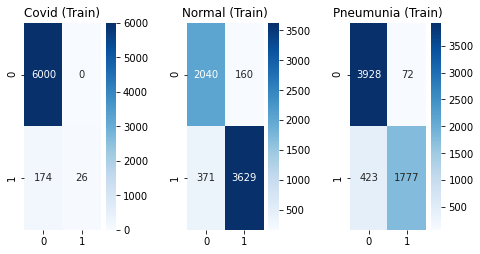

<Figure size 288x360 with 0 Axes>

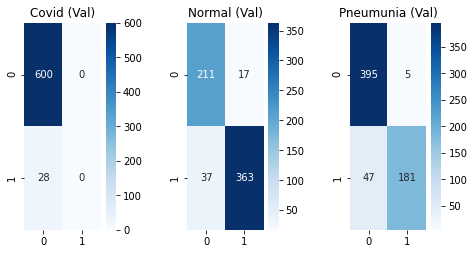

<Figure size 288x360 with 0 Axes>


Epoch 15 : Training Loss: 0.015993, Training Accuracy: 93.763%
	  Validation Loss: 0.018151, Validation Accuracy: 92.781%
	  F1: 0.889431

Epoch 16 : Training Loss: 0.016268, Training Accuracy: 93.640%
	  Validation Loss: 0.018898, Validation Accuracy: 93.047%
	  F1: 0.893409

Epoch 17 : Training Loss: 0.015931, Training Accuracy: 93.661%
	  Validation Loss: 0.017759, Validation Accuracy: 92.994%
	  F1: 0.893031

Epoch 18 : Training Loss: 0.015267, Training Accuracy: 93.941%
	  Validation Loss: 0.017046, Validation Accuracy: 92.887%
	  F1: 0.890344

Epoch 19 : Training Loss: 0.015002, Training Accuracy: 94.129%
	  Validation Loss: 0.016800, Validation Accuracy: 92.941%
	  F1: 0.891073

Epoch 20 : Training Loss: 0.015414, Training Accuracy: 93.935%
	  Validation Loss: 0.016890, Validation Accuracy: 93.100%
	  F1: 0.894309

Epoch 21 : Training Loss: 0.014953, Training Accuracy: 94.145%
	  Validation Loss: 0.017994, Validation Accuracy: 93.206%
	  F1: 0.896104


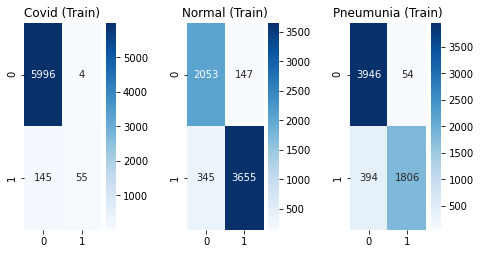

<Figure size 288x360 with 0 Axes>

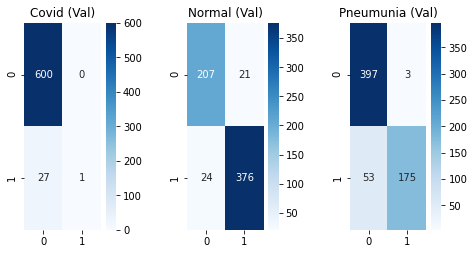

<Figure size 288x360 with 0 Axes>


Epoch 22 : Training Loss: 0.014855, Training Accuracy: 94.183%
	  Validation Loss: 0.016768, Validation Accuracy: 93.577%
	  F1: 0.902811

Epoch 23 : Training Loss: 0.014564, Training Accuracy: 94.199%
	  Validation Loss: 0.016017, Validation Accuracy: 93.843%
	  F1: 0.906300

Epoch 24 : Training Loss: 0.014856, Training Accuracy: 94.188%
	  Validation Loss: 0.016474, Validation Accuracy: 93.471%
	  F1: 0.900243

Epoch 25 : Training Loss: 0.014610, Training Accuracy: 94.091%
	  Validation Loss: 0.016095, Validation Accuracy: 93.843%
	  F1: 0.906602

Epoch 26 : Training Loss: 0.014297, Training Accuracy: 94.392%
	  Validation Loss: 0.017861, Validation Accuracy: 93.790%
	  F1: 0.906624

Epoch 27 : Training Loss: 0.014349, Training Accuracy: 94.371%
	  Validation Loss: 0.015360, Validation Accuracy: 94.002%
	  F1: 0.909383

Epoch 28 : Training Loss: 0.014928, Training Accuracy: 94.188%
	  Validation Loss: 0.016178, Validation Accuracy: 93.418%
	  F1: 0.899676


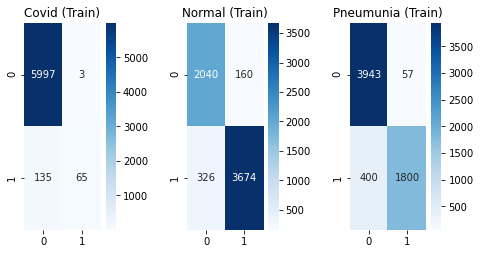

<Figure size 288x360 with 0 Axes>

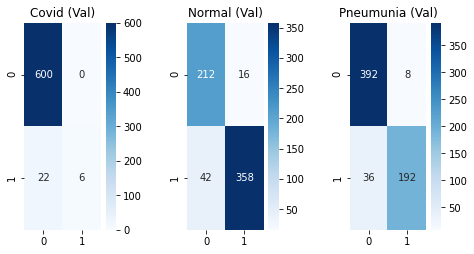

<Figure size 288x360 with 0 Axes>


Epoch 29 : Training Loss: 0.013722, Training Accuracy: 94.575%
	  Validation Loss: 0.015565, Validation Accuracy: 94.161%
	  F1: 0.911576

Epoch 30 : Training Loss: 0.014004, Training Accuracy: 94.554%
	  Validation Loss: 0.015614, Validation Accuracy: 93.843%
	  F1: 0.906300

Epoch 31 : Training Loss: 0.013794, Training Accuracy: 94.581%
	  Validation Loss: 0.016212, Validation Accuracy: 93.631%
	  F1: 0.903382

Epoch 32 : Training Loss: 0.013388, Training Accuracy: 94.602%
	  Validation Loss: 0.015127, Validation Accuracy: 93.737%
	  F1: 0.904685

Epoch 33 : Training Loss: 0.013514, Training Accuracy: 94.758%
	  Validation Loss: 0.015480, Validation Accuracy: 93.684%
	  F1: 0.904110

Epoch 34 : Training Loss: 0.013495, Training Accuracy: 94.785%
	  Validation Loss: 0.015234, Validation Accuracy: 94.214%
	  F1: 0.912450

Epoch 35 : Training Loss: 0.013350, Training Accuracy: 94.618%
	  Validation Loss: 0.018457, Validation Accuracy: 94.321%
	  F1: 0.915012


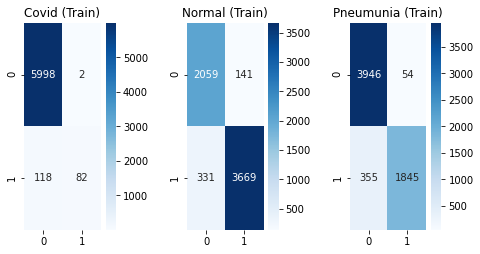

<Figure size 288x360 with 0 Axes>

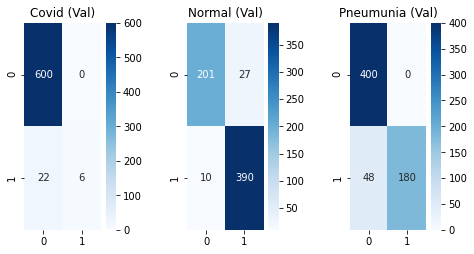

<Figure size 288x360 with 0 Axes>


Epoch 36 : Training Loss: 0.013067, Training Accuracy: 94.892%
	  Validation Loss: 0.015921, Validation Accuracy: 93.949%
	  F1: 0.908946

Epoch 37 : Training Loss: 0.012951, Training Accuracy: 94.790%
	  Validation Loss: 0.016083, Validation Accuracy: 93.896%
	  F1: 0.907779

Epoch 38 : Training Loss: 0.012946, Training Accuracy: 94.925%
	  Validation Loss: 0.015157, Validation Accuracy: 93.843%
	  F1: 0.906300

Epoch 39 : Training Loss: 0.013023, Training Accuracy: 94.747%
	  Validation Loss: 0.015039, Validation Accuracy: 94.480%
	  F1: 0.916800

Epoch 40 : Training Loss: 0.012350, Training Accuracy: 95.054%
	  Validation Loss: 0.018834, Validation Accuracy: 93.896%
	  F1: 0.908658

Epoch 41 : Training Loss: 0.012360, Training Accuracy: 95.140%
	  Validation Loss: 0.016397, Validation Accuracy: 94.161%
	  F1: 0.912141

Epoch 42 : Training Loss: 0.012398, Training Accuracy: 95.075%
	  Validation Loss: 0.014881, Validation Accuracy: 94.480%
	  F1: 0.916933


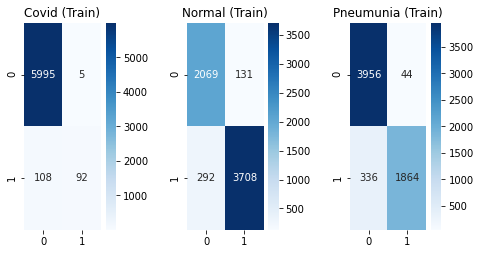

<Figure size 288x360 with 0 Axes>

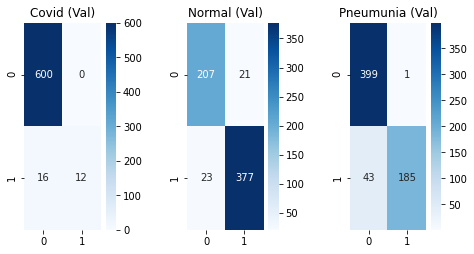

<Figure size 288x360 with 0 Axes>


Epoch 43 : Training Loss: 0.012329, Training Accuracy: 94.989%
	  Validation Loss: 0.014430, Validation Accuracy: 94.427%
	  F1: 0.916201

Epoch 44 : Training Loss: 0.012044, Training Accuracy: 95.151%
	  Validation Loss: 0.014514, Validation Accuracy: 94.374%
	  F1: 0.914516

Epoch 45 : Training Loss: 0.012106, Training Accuracy: 95.204%
	  Validation Loss: 0.015475, Validation Accuracy: 94.108%
	  F1: 0.910986

Epoch 46 : Training Loss: 0.012023, Training Accuracy: 95.247%
	  Validation Loss: 0.014360, Validation Accuracy: 94.480%
	  F1: 0.916933

Epoch 47 : Training Loss: 0.012161, Training Accuracy: 95.199%
	  Validation Loss: 0.015153, Validation Accuracy: 94.427%
	  F1: 0.916600

Epoch 48 : Training Loss: 0.012028, Training Accuracy: 95.258%
	  Validation Loss: 0.014225, Validation Accuracy: 94.480%
	  F1: 0.916933

Epoch 49 : Training Loss: 0.012407, Training Accuracy: 95.081%
	  Validation Loss: 0.014474, Validation Accuracy: 94.798%
	  F1: 0.922222


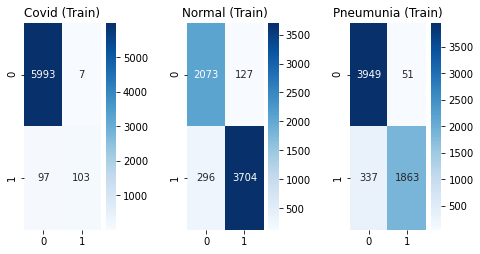

<Figure size 288x360 with 0 Axes>

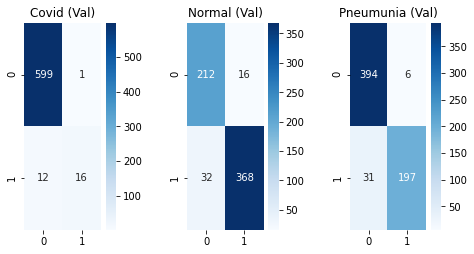

<Figure size 288x360 with 0 Axes>


Epoch 50 : Training Loss: 0.011625, Training Accuracy: 95.376%
	  Validation Loss: 0.014589, Validation Accuracy: 94.692%
	  F1: 0.920635

Epoch 51 : Training Loss: 0.012154, Training Accuracy: 95.258%
	  Validation Loss: 0.014628, Validation Accuracy: 94.586%
	  F1: 0.918790

Epoch 52 : Training Loss: 0.012006, Training Accuracy: 95.199%
	  Validation Loss: 0.016706, Validation Accuracy: 93.471%
	  F1: 0.901046


In [0]:
device = torch.device("cuda")

model.to(device)
model.train()
stats = []

print('Training Started.......')
for epoch in range(Epochs): 

    train_acc = 0.0
    valid_acc = 0.0
    train_loss = 0.0
    valid_loss = 0.0   
    train_pred, train_orig, valid_pred, valid_orig = [], [], [], []

    # Training dataset pass
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        labels = one_hot_label(labels, len(class_names))
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        out = torch.sigmoid(outputs)
        #loss = criterion(outputs, labels) 
        loss = FL.forward(outputs, labels)
        loss.backward()                    
        optimizer.step()                 

        # print statistics
        train_loss += loss.item() * inputs.size(0)

        # Calculate train accuracy and thresholding
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(out > thresh, one, zero)
        
        correct_tensor = predicted.eq(labels.data.view_as(predicted))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * inputs.size(0)

        train_pred.extend(predicted.cpu().numpy())
        train_orig.extend(labels.cpu().numpy())

    train_loss = train_loss / len(trainloader.dataset)
    train_acc = train_acc / len(trainloader.dataset)

    # We don't need to save grads because no backprop is required for validation set
    with torch.no_grad():
        model.eval()
        # Validation dataset pass
        for i, data in enumerate(validloader):
            # get the inputs
            inputs, labels = data
            labels = one_hot_label(labels, len(class_names))
            inputs, labels = inputs.to(device), labels.to(device)

            # Validation loss
            outputs = model(inputs) 
            out = torch.sigmoid(outputs)
            #loss = criterion(outputs, labels)
            loss = FL.forward(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy and thresholding
            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(out > thresh, one, zero)

            correct_tensor = predicted.eq(labels.data.view_as(predicted))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            valid_acc += accuracy.item() * inputs.size(0)

            valid_pred.extend(predicted.cpu().numpy())
            valid_orig.extend(labels.cpu().numpy())

        valid_loss = valid_loss / len(validloader.dataset)
        valid_acc = valid_acc / len(validloader.dataset)

        model.optimizer = optimizer
        stats.append([train_loss, valid_loss, train_acc, valid_acc])
    
    print('\nEpoch',epoch,':',f'Training Loss: {train_loss:.6f},',f'Training Accuracy: {100 * train_acc:.3f}%')
    print(f'\t  Validation Loss: {valid_loss:.6f},',f'Validation Accuracy: {100 * valid_acc:.3f}%')
    f1 = f1_score(np.array(valid_orig), np.array(valid_pred), average='micro')
    print(f'\t  F1: {f1:.6f}')

    # Plot Confusion matrices after some epochs
    if epoch % 7 == 0:
        train_cm = multilabel_confusion_matrix(np.array(train_orig), np.array(train_pred))
        valid_cm = multilabel_confusion_matrix(np.array(valid_orig), np.array(valid_pred))

        fig, ax =plt.subplots(1,3)
        plt.figure(figsize=(4,5))
        fig.tight_layout(pad=3.0)
        fig.subplots_adjust(left = 0.025, right = 1, wspace=.7)
        sns.heatmap(train_cm[0], annot=True, cmap='Blues', fmt="d", ax=ax[0])
        sns.heatmap(train_cm[1], annot=True, cmap='Blues', fmt="d", ax=ax[1])
        sns.heatmap(train_cm[2], annot=True, cmap='Blues', fmt="d", ax=ax[2])
        ax[0].set_title('Covid (Train)')
        ax[1].set_title('Normal (Train)')
        ax[2].set_title('Pneumunia (Train)')
        plt.show()

        fig1, ax1 =plt.subplots(1,3)
        plt.figure(figsize=(4,5))
        fig1.tight_layout(pad=3.0)
        fig1.subplots_adjust(left = 0.025, right = 1, wspace=.7)
        sns.heatmap(valid_cm[0], annot=True, cmap='Blues', fmt="d", ax=ax1[0])
        sns.heatmap(valid_cm[1], annot=True, cmap='Blues', fmt="d", ax=ax1[1])
        sns.heatmap(valid_cm[2], annot=True, cmap='Blues', fmt="d", ax=ax1[2])
        ax1[0].set_title('Covid (Val)')
        ax1[1].set_title('Normal (Val)')
        ax1[2].set_title('Pneumunia (Val)')
        plt.show()

    stat = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
    torch.save(model, './drive/My Drive/FINALwith_focalloss_resnet18.pth')


print('Finished Training')
plotCurves(stat)

In [0]:
plotCurves(stat)

In [0]:
stat.to_csv('./drive/My Drive/finalPLOT2.csv')

Test data predictions

In [0]:
# Load the trained model
#model = torch.load('./drive/My Drive/Covid_focal_loss_weights/res18_focal_loss.pth')

In [0]:
class TestDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return img_loc, tensor_image

In [0]:
test_transforms = transforms.Compose([transforms.Resize((224,244), 2),
                                      transforms.ToTensor()])

test_dataset = TestDataSet(data_dir + "/Test/", transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [0]:
# Prediction on Test dataset
device = torch.device("cuda")
model = model.to(device)
pred, names = [], []
with torch.no_grad():
    model.eval()
    # Test dataset pass
    for i, data in enumerate(testloader):
        # get the inputs
        name, inputs = data
        inputs = inputs.to(device)

        outputs = model(inputs) 
        outs = nn.Sigmoid()
        out = outs(outputs)

        #Predicting labels
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(out > thresh, one, zero)
        pred.extend(predicted.data.cpu().numpy().astype(int))
        names.extend(name)

In [0]:
img = pd.DataFrame(names, columns=['image name'])

In [0]:
label = pd.DataFrame(pred, columns=['Covid Class', 'Normal Class', 'Pneumunia Class'])

In [0]:
csv = pd.concat([img, label], axis=1)

In [0]:
columns_titles = ["image name", "Covid Class", "Pneumunia Class", "Normal Class"]
csv = csv.reindex(columns=columns_titles)
csv.head(10)

,image name,Covid Class,Pneumunia Class,Normal Class
0,A_05_Part_02_Dataset/Test/0.png,0,0,1
1,A_05_Part_02_Dataset/Test/1.png,0,0,1
2,A_05_Part_02_Dataset/Test/2.png,0,0,1
3,A_05_Part_02_Dataset/Test/3.png,0,1,0
4,A_05_Part_02_Dataset/Test/4.png,0,0,1
5,A_05_Part_02_Dataset/Test/5.png,0,1,0
6,A_05_Part_02_Dataset/Test/6.png,0,0,1
7,A_05_Part_02_Dataset/Test/7.png,0,0,1
8,A_05_Part_02_Dataset/Test/8.png,0,1,0
9,A_05_Part_02_Dataset/Test/9.jpg,0,1,0


In [0]:
csv.to_csv('./drive/My Drive/BEST_resnet_test.csv')